In [1]:
from openmmtools.constants import kB
from simtk import unit
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
from neutromeratio.utils import *
import matplotlib.pyplot as plt
import pickle
import torchani
import torch

# temperature, mass, and related constants
temperature = 300 * unit.kelvin
kT = kB * temperature
mass = (12.0 * unit.dalton)
sigma_v = np.sqrt(kB * temperature / mass)

# openmm units
mass_unit = unit.dalton
distance_unit = unit.nanometer
time_unit = unit.femtosecond
energy_unit = unit.kilojoule_per_mole
speed_unit = distance_unit / time_unit
force_unit = unit.kilojoule_per_mole / unit.nanometer

# ANI-1 units and conversion factors
ani_distance_unit = unit.angstrom
hartree_to_kJ_mol = 2625.499638
ani_energy_unit = hartree_to_kJ_mol * unit.kilojoule_per_mole # simtk.unit doesn't have hartree?
nm_to_angstroms = (1.0 * distance_unit) / (1.0 * ani_distance_unit) 


In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
#name = 'molDWRow_37'
name = 'molDWRow_590'
#name = 'molDWRow_298'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_37'

# specify a run number
run = 1
# which tautomer should be simulated [1/2]
tautomer_idx = 2
# number of time steps
n_steps = 10000

In [3]:
device = torch.device('cpu')
model = torchani.models.ANI1ccx()
model = model.to(device)
torch.set_num_threads(4)

smiles = exp_results[name][f"t{tautomer_idx}-smiles"]


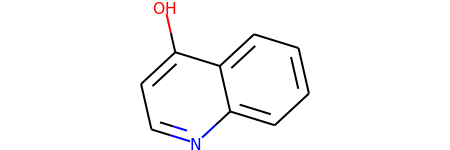

In [4]:
Chem.MolFromSmiles(smiles)

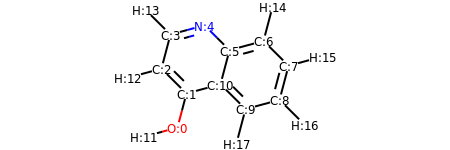

100%|██████████| 10000/10000 [13:35<00:00, 12.00it/s, |force|=6.92e+3]


In [5]:
# generate both rdkit mol
mols = { f"t{tautomer_idx}" : generate_rdkit_mol(smiles)}

write_pdb(mols[f"t{tautomer_idx}"], name, f"t{tautomer_idx}")

# continueing with only one mol structure
mol = mols[f"t{tautomer_idx}"]
ani_input = from_mol_to_ani_input(mol)

# extract hydrogen acceptor idx for to_mol
species = model.species_to_tensor(ani_input['atom_list']).to(device).unsqueeze(0)

# initial conditions: coordinates from example were given in units of angstroms   
x0_in_angstroms = np.array(ani_input['coord_list']) * unit.angstrom

# generating mdtraj topology object
topology = md.load(f"../data/md_sampling/{name}/{name}_t{tautomer_idx}.pdb").topology

traj_in_nm = []
trajectory, x, energies = langevin(device, model, ani_input['atom_list'], x0_in_angstroms, ANI1ccx_force_and_energy, n_steps=n_steps, stepsize=0.5*unit.femtosecond, temperature=temperature, platform='cpu', progress_bar=True)
traj_in_nm += [x / unit.nanometer for x in trajectory]

# generate mdtraj traj object
ani_traj = md.Trajectory(traj_in_nm, topology)
ani_traj = ani_traj.superpose(ani_traj[0]) # RMSD align onto first frame
ani_traj.save(f"../data/md_sampling/{name}/{name}_t{tautomer_idx}_run{run}_anicxx.dcd")

f = open(f"../data/md_sampling/{name}/{name}_t{tautomer_idx}_run{run}_anicxx_energy.csv", 'w')
for idx, e in enumerate(energies):
    f.write('{}, {}\n'.format(idx, e))
f.close()


In [6]:
topology = md.load(f"../data/md_sampling/{name}/{name}_t{tautomer_idx}.pdb").topology
traj_file = f"../data/md_sampling/{name}/{name}_t{tautomer_idx}_run{run}_anicxx.dcd"
ani_traj = md.load(traj_file, top=topology)

view = nglview.show_mdtraj(ani_traj[::10])
view

NGLWidget(count=1001)

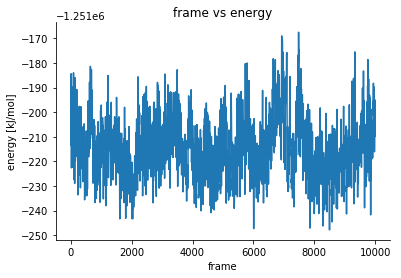

In [7]:
f = open(f"../data/md_sampling/{name}/{name}_t{tautomer_idx}_run{run}_anicxx_energy.csv", 'r')
energy = []
for line in f:
    idx, e = line.split(',')
    energy.append(float(e))

ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# insert plotting code
plt.plot(energy)
plt.xlabel('frame')
plt.ylabel('energy [kJ/mol]')
plt.title('frame vs energy')

plt.savefig(f"../data/md_sampling/{name}/energy_{name}_t{tautomer_idx}_run{run}.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#from nglview.contrib.movie import MovieMaker
#movie = MovieMaker(view, output='my.gif')
#movie.make()
